In [1]:
# %load "bp_train.py"

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import bp_input

# batch size
batch_size = 5
# input vector size
hidden_size = 300
# unroll rnn with truncated bp,
# with a fixed number of number(num_step) cells
num_steps = 53
# forget bias
forget_bias = 1.0
# keep probability
keep_prob = 0.5
# num of layers in multiple layer lstm
num_layers = 2
# num of output classes 
num_classes = 6
# max epoch
max_epoch = 100

# input data
(tr_d, tr_l), (te_d, te_l) = bp_input.bp_raw_data(test_size=10)

train_input = bp_input.BPInput(batch_size, tr_d, tr_l)

inputs, labels, epoch_size = train_input.inputs, train_input.targets, train_input.epoch_size
inputs = tf.unstack(inputs, num=num_steps, axis=1)

In [2]:
# analyse
def analyse(p, l, verbose=False):
    ppd = pd.DataFrame(p)
    lpd = pd.DataFrame(l)
    # all sample
    m = (lpd != 0) 
    total_size = m.sum().sum()
    acc_size = ((ppd == lpd) & m).sum().sum()
    acc = 1.0 * acc_size / total_size
    # pos sample
    m2 = (lpd > 1)
    pos_size = m2.sum().sum()
    pos_p = lpd[((ppd == lpd) & m2)]
    pos_acc_size = ((ppd == lpd) & m2).sum().sum()
    pos_acc = 1.0 * pos_acc_size / pos_size
    # neg sample
    neg_size = total_size - pos_size
    neg_acc_size = acc_size - pos_acc_size
    neg_acc = 1.0 * neg_acc_size / neg_size
    # print to screen
    if verbose:
        print("total_size: %d, acc_size: %d, acc: %.3f" % (total_size, acc_size, acc))
        print("pos_size: %d, pos_acc_size: %d, pos_acc: %.3f" % (pos_size, pos_acc_size, pos_acc))
        print("neg_size: %d, neg_acc_size: %d, neg_acc: %.3f" % (neg_size, neg_acc_size, neg_acc))
    return acc, pos_acc, neg_acc


def draw(p, l):
    assert p.shape == l.shape
    f1 = plt.subplot(121)
    i1 = f1.imshow(p, vmin=0, vmax=5)
    plt.colorbar(i1)
    f2 = plt.subplot(122)
    i2 = f2.imshow(l, vmin=0, vmax=5)
    plt.show()

In [3]:
# inference
# forward lstm layer
lstm_fw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_fw = tf.contrib.rnn.DropoutWrapper(lstm_fw, output_keep_prob=keep_prob)

multi_lstm_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw] * num_layers)

initial_state_fw = multi_lstm_fw.zero_state(batch_size, tf.float32)

# backward lstm layer
lstm_bw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_bw = tf.contrib.rnn.DropoutWrapper(lstm_bw, output_keep_prob=keep_prob)

multi_lstm_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw] * num_layers)

initial_state_bw = multi_lstm_bw.zero_state(batch_size, tf.float32)

# bilstm
outputs, output_state_fw, output_state_bw = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=multi_lstm_fw, cell_bw=multi_lstm_bw, inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)


In [4]:





# softmax layer
softmax_w = tf.get_variable("softmax_w", [2*hidden_size, num_classes], dtype=tf.float32)
softmax_b = tf.get_variable("softmax_b", [num_classes], dtype=tf.float32)

# output layer
output = tf.reshape(tf.concat(outputs, 1), [-1, 2 * hidden_size])
logits = tf.matmul(output, softmax_w) + softmax_b

# weights for different label 
label_flat = tf.reshape(labels, [-1])
weights = tf.to_float(tf.clip_by_value(label_flat, clip_value_min=0, clip_value_max=2))
weights = tf.square(weights)
mask = tf.sign(weights)

# loss and cost
loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    logits=[logits],
    targets=[label_flat],
    weights=[mask])
cost = tf.reduce_sum(loss) / batch_size

# optimizer and train operation
optimizer = tf.train.GradientDescentOptimizer(0.05)
train_op = optimizer.minimize(cost)

# prediction
prediction = tf.argmax(logits, 1) * tf.to_int64(mask)

# run an epoch
def run_epoch(sess):
    start_time = time.time()
    costs = 0.0
    iters = 0.0
    # zero state
    state_fw = sess.run(initial_state_fw)
    state_bw = sess.run(initial_state_bw)
    
    preds = []
    for step in range(epoch_size):
        # construct feed_dict
        feed_dict = {}
        for i, (c, h) in enumerate(initial_state_fw):
            feed_dict[c] = state_fw[i].c
            feed_dict[h] = state_fw[i].h
        for i, (c, h) in enumerate(initial_state_bw):
            feed_dict[c] = state_bw[i].c
            feed_dict[h] = state_bw[i].h
        # 
        c, state_fw, state_bw, _, pred = sess.run(
            [cost, output_state_fw, output_state_bw, train_op, prediction],
            feed_dict)
        # 
        costs += c
        iters += num_steps
        preds.append(pred)
        if step % (epoch_size // 10) == 0:
            print("%.3f perplexity: %.3f speed: %.0f wps" %
                (step * 1.0 / epoch_size, np.exp(costs / iters),
                 iters * batch_size / (time.time() - start_time)))
    preds = np.vstack(preds).reshape(-1, 53)
    return preds


# saver 
saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=None)

# saver path 
if not os.path.exists("ckpt_files"):
    os.mkdir("ckpt_files")
ckpt_path = "ckpt_files/model.ckpt"


In [6]:
# session 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# coord for threads 
coord = tf.train.Coordinator()

threads = tf.train.start_queue_runners(sess=sess, coord=coord)

# train several epoches
for i in range(max_epoch):
    print("epoch: %4d" % i)
    p = run_epoch(sess)
    
    analyse(p, tr_l[: p.shape[0]], verbose=True)
    
    if i % 10 == 0 or i + 1 == max_epoch:
        saver.save(sess, ckpt_path, global_step=i, write_meta_graph=False)
    #saver.restore(sess, ckpt_path + "-%d" % global_step)
    
    

# stop threads 
coord.request_stop()
# wait for all threads to stop
coord.join(threads)

epoch:    0
0.000 perplexity: 1.493 speed: 88 wps
0.083 perplexity: 1.423 speed: 162 wps
0.167 perplexity: 1.378 speed: 196 wps
0.250 perplexity: 1.346 speed: 215 wps
0.333 perplexity: 1.329 speed: 228 wps
0.417 perplexity: 1.319 speed: 237 wps
0.500 perplexity: 1.315 speed: 242 wps
0.583 perplexity: 1.311 speed: 247 wps
0.667 perplexity: 1.300 speed: 251 wps
0.750 perplexity: 1.298 speed: 255 wps
0.833 perplexity: 1.292 speed: 257 wps
0.917 perplexity: 1.290 speed: 257 wps
total_size: 2233, acc_size: 1828, acc: 0.819
pos_size: 359, pos_acc_size: 4, pos_acc: 0.011
neg_size: 1874, neg_acc_size: 1824, neg_acc: 0.973
INFO:tensorflow:ckpt_files/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
epoch:    1
0.000 perplexity: 1.255 speed: 277 wps
0.083 perplexity: 1.290 speed: 282 wps
0.167 perplexity: 1.274 speed: 283 wps
0.250 perplexity: 1.266 speed: 283 wps
0.333 perplexity: 1.264 speed: 263 wps
0.417 perplexity: 1.263 speed: 266 wps
0.500 perplexity: 1.266 speed: 268

IndexError: index 120 is out of bounds for axis 1 with size 53

In [8]:
p.shape[0]

120

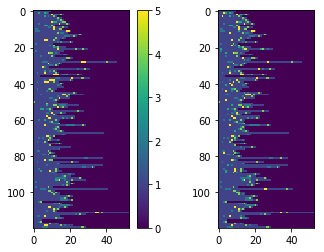

In [9]:
draw(p, tr_l[: p.shape[0]])